downloading date from start date: 2023-12-18 00:34:57.861891
downloading date from end date: 2024-04-16 00:34:57.861891
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  

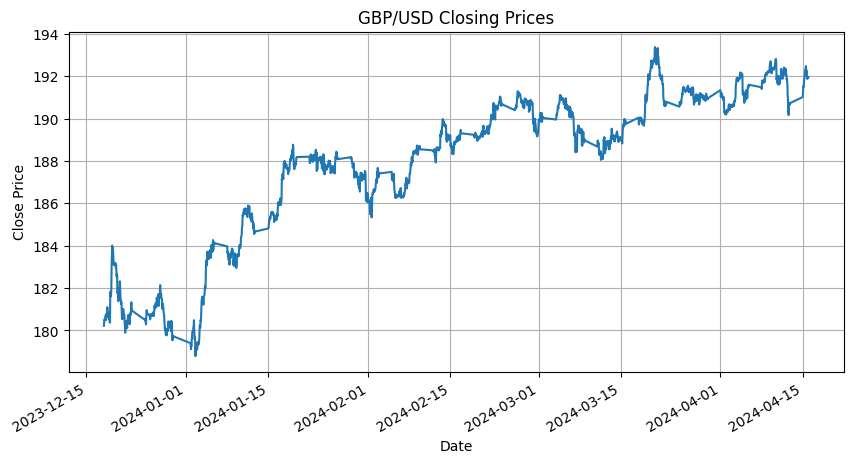

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import mplfinance as mpf




# forex_symbols = [
#     'GBPJPY=X', 'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 
#     'AUDUSD=X', 'USDCAD=X', 'USDNOK=X',
#     'EURGBP=X', 'EURJPY=X', 'AUDJPY=X', 'NZDUSD=X', 
#     'EURCHF=X', 'EURCAD=X', 'GBPCAD=X', 'GBPAUD=X'
# ]


forex_symbols= [
  
# 'GBPJPY=X', 'GBPUSD=X', 'USDJPY=X',  'USDNOK=X','GBPAUD=X', 'EURUSD=X', 'USDCHF=X', 
#     'AUDUSD=X', 'USDCAD=X',  'EURGBP=X', 'EURJPY=X', 'AUDJPY=X',
#      'NZDUSD=X', 'EURCHF=X', 'EURCAD=X', 'GBPCAD=X', 
        'GBPJPY=X', 'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 
    'AUDUSD=X', 'USDCAD=X', 'USDNOK=X',
    'EURGBP=X', 'EURJPY=X', 'AUDJPY=X', 'NZDUSD=X', 
    'EURCHF=X', 'EURCAD=X', 'GBPCAD=X', 'GBPAUD=X'
]


intervals =  ['1m', '2m', '5m', '30m','1h', '1d']

# set the symbool and interval size
ticker = forex_symbols[0]
inter = intervals[4]


# set the time interval parameters
m_days_back_from_start =120


# ---|start_date| -----------|end date|------


end_date = datetime.now()-timedelta(days=0)
start_date = end_date - timedelta(days=m_days_back_from_start)


print(f'downloading date from start date: {start_date}')
print(f'downloading date from end date: {end_date}')




def download_and_process_data(forex_data, symbols, interval, start, end):
    
    
    for symbol in symbols:
        data = yf.download(symbol, start=start, end=end, interval=interval)
        column_name = symbol
        forex_data[column_name] = data['Close']
    
    return 



forex_data = yf.download(ticker, start=start_date, end=end_date, interval= inter)
download_and_process_data(forex_data, forex_symbols[1:], inter, start_date, end_date)


a = forex_data.shape[0]



def remove_weekend_data(forex_data):
    if not isinstance(forex_data.index, pd.DatetimeIndex):
        forex_data.index = pd.to_datetime(forex_data.index)
    
    def is_within_market_hours(timestamp):
        if timestamp.weekday() == 4 and timestamp.hour >= 21:  # 21:00 UTC is 5 PM EST
            return False
        elif timestamp.weekday() == 5:
            return False
        elif timestamp.weekday() == 6 and timestamp.hour < 21:  # Market opens at 5 PM EST, which is 21:00 UTC
            return False
        return True
    
    return forex_data[forex_data.index.map(is_within_market_hours)]


forex_data  = remove_weekend_data(forex_data)
b = forex_data.shape[0]
print(a-b)
print(forex_data.shape)
print(forex_data.columns)


print(forex_data.iloc[0])



import matplotlib.pyplot as plt

forex_data['Close'].plot(figsize=(10,5))
plt.title('GBP/USD Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [2]:
import pandas_ta as ta

def add_technical_indicators(forex_data):
    SHORT_WINDOW = 14
    LONG_WINDOW = 50
    SIGNAL_WINDOW = 9
    RSI_WINDOW = SHORT_WINDOW
    BBANDS_WINDOW = 20
    STOCH_WINDOW = 14
    MACD_FAST = 14
    MACD_SLOW = 26
    MACD_SIGNAL = SHORT_WINDOW
    ADX_WINDOW = 14  # Common period length for ADX calculation
    

    # forex_data['SMA'] = forex_data['Close'].rolling(window=SHORT_WINDOW).mean()
    # forex_data['EMA'] = forex_data['Close'].ewm(span=SHORT_WINDOW*4, adjust=False).mean()
    EMA_fast = forex_data['Close'].ewm(span=MACD_FAST, adjust=False).mean()
    EMA_slow = forex_data['Close'].ewm(span=MACD_SLOW, adjust=False).mean()
    forex_data['MACD'] = EMA_fast - EMA_slow
    # forex_data['MACD_Signal'] = forex_data['MACD'].ewm(span=MACD_SIGNAL, adjust=False).mean()
    delta = forex_data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_WINDOW).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_WINDOW).mean()
    RS = gain / loss
    forex_data['RSI'] = 100 - (100 / (1 + RS))

    BBANDS_WINDOW = 20  # The length for the moving average and standard deviation calculation
    STANDARD_DEVIATIONS = 2  # The multiplier for the standard deviation to set the upper and lower bands

    forex_data['BB_Middle'] = forex_data['Close'].rolling(window=BBANDS_WINDOW).mean()

    forex_data['BB_Upper'] = forex_data['BB_Middle'] + (forex_data['Close'].rolling(window=BBANDS_WINDOW).std() * STANDARD_DEVIATIONS)
    forex_data['BB_Lower'] = forex_data['BB_Middle'] - (forex_data['Close'].rolling(window=BBANDS_WINDOW).std() * STANDARD_DEVIATIONS)
 
    forex_data['BB_RANGE'] = forex_data['BB_Upper'] -forex_data['BB_Lower']
   
    forex_data['Distance_to_BB_Upper'] = forex_data['BB_Upper'] - forex_data['Close']
    forex_data['Distance_to_BB_Lower'] = forex_data['Close'] - forex_data['BB_Lower']



           
    PERIODS = 10  # The lookback period for the volatility calculation
    DAYS_PER_YEAR = 252  # Trading days per year for annualization
    
    # # Calculate the true range within the volatility calculation
    true_range = np.maximum(np.maximum(forex_data['High'] - forex_data['Low'], 
                                       abs(forex_data['High'] - forex_data['Close'].shift())), 
                            abs(forex_data['Low'] - forex_data['Close'].shift()))
    
    # Calculate and store only the volatility in the DataFrame
    forex_data['Volatility_OHLC'] = true_range.rolling(window=PERIODS).std()
        

    forex_data.dropna(inplace=True)
    window_size = 10  # Example window size
    # forex_data['Moving Average'] = forex_data['Close'].rolling(window=SHORT_WINDOW, min_periods=1).mean()
    # forex_data['Moving Average1'] = forex_data['Close'].rolling(window=SHORT_WINDOW*5, min_periods=1).mean()
    forex_data['Moving Average2'] = forex_data['Close'].rolling(window=SHORT_WINDOW*2, min_periods=1).mean()
    forex_data['Moving Average3'] = forex_data['Close'].rolling(window=SHORT_WINDOW*3, min_periods=1).mean()
    # forex_data['Volatility'] = forex_data['Close'].rolling(window=SHORT_WINDOW, min_periods=1).std(ddof=0)

    forex_data['MA_diff'] = forex_data['Close'] - forex_data['Moving Average2']

    forex_data['ADX'] = average_directional_index(forex_data['High'], forex_data['Low'], forex_data['Close'])

    # adx_ind = forex_data.ta.adx(length=ADX_WINDOW)
    # forex_data = pd.concat([forex_data, adx_ind], axis=1)

    # def moving_average_slope(data, window):
    #     ma = data.rolling(window=window, min_periods=1).mean()
    #     slope = (ma - ma.shift(1)) / window
    #     return slope

    # forex_data['Moving Average Slope'] = moving_average_slope(forex_data['Close'], SHORT_WINDOW)
    



    

    return forex_data







def average_directional_index(high_prices, low_prices, close_prices, period=14):
    """
    Calculate Average Directional Index (ADX)
    
    Parameters:
        high_prices (Series): High prices of the asset.
        low_prices (Series): Low prices of the asset.
        close_prices (Series): Close prices of the asset.
        period (int): Number of periods. Default is 14.
    
    Returns:
        Series: Average Directional Index (ADX) values.
    """
    high_low_diff = high_prices - low_prices
    high_close_diff = (high_prices - close_prices.shift(1)).abs()
    low_close_diff = (low_prices - close_prices.shift(1)).abs()
    
    plus_dm = high_close_diff.where((high_close_diff > low_close_diff) & (high_close_diff > 0), 0)
    minus_dm = low_close_diff.where((low_close_diff > high_close_diff) & (low_close_diff > 0), 0)
    
    tr = high_low_diff.combine(high_close_diff.combine(low_close_diff, max), max)
    
    atr = tr.rolling(window=period).mean()
    plus_di = (plus_dm / atr).rolling(window=period).mean() * 100
    minus_di = (minus_dm / atr).rolling(window=period).mean() * 100
    
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).abs()).rolling(window=period).mean() * 100
    adx = dx.rolling(window=period).mean()
    
    return adx







def plot_indicators(forex_data, indicator_indices):
    # Create a dictionary of indicator names mapped to their column names in forex_data
    indicator_names = {
        'MACD': 'MACD',
        'MACD_Signal': 'MACD_Signal',
        'RSI': 'RSI',
        'Moving Average': 'Moving Average',
        'Moving Average1': 'Moving Average1',
        'Moving Average2': 'Moving Average2',
        'Volatility': 'Volatility',
        'ADX': 'ADX',
        'Moving Average Slope':'Moving Average Slope'
    }

    # Plot setup
    plt.figure(figsize=(14, 7))

    # Loop through each indicator index provided
    for idx in indicator_indices:
        # Match the index to the indicator name
        indicator_key = list(indicator_names.keys())[idx]
        indicator_label = indicator_names[indicator_key]

        # Plot the indicator if it exists in the DataFrame
        if indicator_label in forex_data.columns:
            plt.plot(forex_data.index, forex_data[indicator_label], label=indicator_label)

    # Final plot adjustments
    plt.legend()
    plt.show()


forex_data = add_technical_indicators(forex_data)



In [3]:

def add_shannon(forex_data):
    WINDOW_SIZE = 16
    
    # Calculate returns based on closing prices (analogous to V1/V2 without bid/ask prices)
    forex_data['Return'] = forex_data['Close'].pct_change()
    
    # Approximate the bid-ask spread return as the high-low spread return
    forex_data['HL_Spread'] = (forex_data['High'] - forex_data['Low']) 
    
    # Calculate the mean price based on high and low (analogous to V4/V5 without bid/ask prices)
    forex_data['Mean_HL_Price'] = (forex_data['High'] + forex_data['Low']) / 2
    
    # Calculate the mean mid-price based on open and close (analogous to V6)
    forex_data['Mean_OC_Price'] = (forex_data['Open'] + forex_data['Close']) / 2
    
    # Calculate the volatility of mid-price (we will use Close price as a proxy for mid-price)
    forex_data['Close_Volatility'] = forex_data['Close'].rolling(window=2).std(ddof=0)
    
    # The V9 (volatility) will be the standard deviation of the Close price over the window size
    forex_data['Volatility'] = forex_data['Close'].rolling(window=WINDOW_SIZE).std(ddof=0)
    
    # Trade intensity cannot be calculated without trade count or volume data.
    # In place of V10, we could use the range as a proxy for activity
    forex_data['Range'] = forex_data['High'] - forex_data['Low']
    return forex_data

forex_data =  add_shannon(forex_data)
    

In [4]:
df = pd.DataFrame(forex_data)


In [5]:
import cstick as cp
df= cp.doji(df)

# df= cp.three_crows(df)
# x = cp.get_max_min(df,  smoothing=4, window_range=16)
# df = cp.adx(df, 5)

df = cp.hammer(df)
# print(x)


In [6]:
def identify_candlestick_patterns(df):
    # Bearish Engulfing
    bearish_engulfing = (
        (df['Close'].shift(-1) > df['Open'].shift(-1)) &
        (df['Open'] > df['Close']) &
        (df['Open'] >= df['Close'].shift(-1)) &
        (df['Close'] < df['Open'].shift(-1)) &
        (df['Close'] < df['Close'].shift(-1)) &  
        (df['Open'] > df['Open'].shift(-1)) 
    )
    bullish_engulfing = (
        (df['Close'].shift(-1) < df['Open'].shift(-1)) &
        (df['Open'] < df['Close']) &
        (df['Open'] <= df['Close'].shift(-1)) &
        (df['Close'] > df['Open'].shift(-1)) &
        (df['Close'] > df['Close'].shift(-1)) &  
        (df['Open'] < df['Open'].shift(-1)) 
    )


    bearish_harami = (df['Open'].shift(1) < df['Close'].shift(1)) & \
                     (df['Open'] > df['Close']) & \
                     (df['Open'] < df['Close'].shift(1)) & \
                     (df['Close'] > df['Open'].shift(1))

    bullish_harami = (df['Open'].shift(1) > df['Close'].shift(1)) & \
                     (df['Open'] < df['Close']) & \
                     (df['Open'] > df['Close'].shift(1)) & \
                     (df['Close'] < df['Open'].shift(1))

    three_white_soldiers = (df['Close'] > df['Open']) & \
                           (df['Close'].shift(1) > df['Open'].shift(1)) & \
                           (df['Close'].shift(2) > df['Open'].shift(2)) & \
                           (df['Open'].shift(1) < df['Close'].shift(2)) & \
                           (df['Open'] < df['Close'].shift(1)) & \
                           (df['Close'] > df['Close'].shift(1)) & \
                           (df['Close'].shift(1) > df['Close'].shift(2))


    basic_conditions = (df['Close'] > df['Open']) & \
                       (df['Close'].shift(1) > df['Open'].shift(1)) & \
                       (df['Close'].shift(2) > df['Open'].shift(2))
    
    # Flexible conditions for overlaps and progressions
    tolerance = 0.9
    overlap_conditions = (df['Open'].shift(1) * tolerance < df['Close'].shift(2)) & \
                         (df['Open'] * tolerance < df['Close'].shift(1)) & \
                         (df['Close'] > df['Close'].shift(1) * tolerance) & \
                         (df['Close'].shift(1) > df['Close'].shift(2) * tolerance)
    
    th_white_soldiers = basic_conditions & overlap_conditions

    tolerance = 0.9
    midpoint_tolerance = (df['Open'].shift(1) + df['Close'].shift(1)) / 2 * (1 + (1 - tolerance))

    th_black_soldiers = (
        (df['Close'].shift(1) > df['Open'].shift(1)) &  # Previous candle is bullish
        (df['Open'] > df['Close']) &                    # Current candle is bearish
        (df['Open'] > df['Close'].shift(1)) &           # Gaps up at open
        (df['Close'] < midpoint_tolerance) &            # Closes below the adjusted midpoint of the previous candle
        (df['Close'] > df['Open'].shift(1))             # Closes above the open of the previous candle
    )

    
    
    

    dark_cloud_cover = (
        (df['Close'].shift(1) > df['Open'].shift(1)) &  # Previous candle is bullish
        (df['Open'] > df['Close']) &                    # Current candle is bearish
        (df['Open'] > df['Close'].shift(1)) &           # Gaps up at open
        (df['Close'] < (df['Open'].shift(1) + df['Close'].shift(1)) / 2) &  # Closes below the midpoint of the previous candle
        (df['Close'] > df['Open'].shift(1))             # Closes above the open of the previous candle
    )

    # Piercing Pattern
    piercing_pattern = (
        (df['Close'].shift(1) < df['Open'].shift(1)) &  # Previous candle is bearish
        (df['Open'] < df['Close']) &                    # Current candle is bullish
        (df['Open'] < df['Close'].shift(1)) &           # Gaps down at open
        (df['Close'] > (df['Open'].shift(1) + df['Close'].shift(1)) / 2) &  # Closes above the midpoint of the previous candle
        (df['Close'] < df['Open'].shift(1))             # Closes below the open of the previous candle
    )
    three_line_strike = (
        (df['Close'].shift(-3) <= df['Close'].shift(-2)) &
        (df['Close'].shift(-2) <= df['Close'].shift(-1)) &
        (df['Open'].shift(-3) <= df['Open'].shift(-2)) &
        (df['Open'].shift(-2) <= df['Open'].shift(-1)) &
        (df['Close'] <= df['Open'].shift(-3)) &
        (df['Open'] >= df['Close'].shift(-1)) 
    )
    three_line_strike_bull = (
        (df['Close'].shift(-3) >= df['Close'].shift(-2)) &
        (df['Close'].shift(-2) >= df['Close'].shift(-1)) &
        (df['Open'].shift(-3) >= df['Open'].shift(-2)) &
        (df['Open'].shift(-2) >= df['Open'].shift(-1)) &
        (df['Close'] >= df['Open'].shift(-3)) &
        (df['Open'] <= df['Close'].shift(-1)) 
    )

    three_outside_up = (
        (df['Close'].shift(-1) > df['Open'].shift(-1)) &  # First candle is bullish
        (df['Close'].shift(-2) < df['Open'].shift(-2)) &  # Prior to the first candle is bearish
        (df['Close'] > df['Open']) &  # Last candle is bullish and closes above the first candle's close
        (df['Open'].shift(-1) < df['Close'].shift(-2)) &  # First candle opens within the body of the prior candle
        (df['Close'].shift(-1) > df['Open'])  # First candle closes above the open of the last candle
    )
    
    three_outside_down = (
        (df['Open'].shift(-1) > df['Close'].shift(-1)) &  # First candle is bearish
        (df['Close'].shift(-2) > df['Open'].shift(-2)) &  # Prior to the first candle is bullish
        (df['Close'] < df['Open']) &  # Last candle is bearish and closes below the first candle's close
        (df['Open'].shift(-1) > df['Close'].shift(-2)) &  # First candle opens within the body of the prior candle
        (df['Close'].shift(-1) < df['Open'])  # First candle closes below the open of the last candle
    )

    three_inside_down = (
        (df['Close'].shift(-2) > df['Open'].shift(-2)) &  # The first candle is bullish
        (df['Open'].shift(-1) > df['Close'].shift(-1)) &  # The second candle is bearish
        (df['Open'].shift(-1) < df['Close'].shift(-2)) &  # The second candle opens below the close of the first candle
        (df['Close'].shift(-1) < df['Open'].shift(-2)) &  # The second candle closes within the body of the first candle
        (df['Close'] < df['Close'].shift(-1)) &  # The third candle is bearish and closes below the second candle's close
        (df['Close'] < df['Open'])  # The third candle closes below its open
    )
    three_inside_up = (
        (df['Close'].shift(-2) < df['Open'].shift(-2)) &  # The first candle is bullish
        (df['Open'].shift(-1) < df['Close'].shift(-1)) &  # The second candle is bearish
        (df['Open'].shift(-1) > df['Close'].shift(-2)) &  # The second candle opens below the close of the first candle
        (df['Close'].shift(-1) > df['Open'].shift(-2)) &  # The second candle closes within the body of the first candle
        (df['Close'] > df['Close'].shift(-1)) &  # The third candle is bearish and closes below the second candle's close
        (df['Close'] > df['Open'])  # The third candle closes below its open
    )


    df['Engulfing'] = 0
    df['Harami'] = 0
    df['Three_crows'] = 0
    # df['Piercing'] = 0
    # df['Three line Strike'] = 0
    # df['Three Outside'] = 0
    # df['Three Inside'] = 0
    
    
    df.loc[bearish_engulfing, 'Engulfing'] -= 1
    df.loc[bullish_engulfing, 'Engulfing'] += 1
    df.loc[bearish_harami, 'Harami'] -= 1
    df.loc[bullish_harami, 'Harami'] += 1
    
    # df.loc[three_white_soldiers, 'Three_crows'] += 1
    df.loc[th_white_soldiers, 'Three_crows'] += 2
    
    # df.loc[dark_cloud_cover, 'Three_crows'] -= 1
    df.loc[th_black_soldiers, 'Three_crows'] -= 2
    
    # df.loc[piercing_pattern, 'Piercing'] += 1
    # df.loc[three_line_strike, 'Three line Strike'] -= 1
    # df.loc[three_line_strike_bull, 'Three line Strike'] += 1
    # df.loc[three_outside_up, 'Three Outside'] += 1
    # df.loc[three_outside_down, 'Three Outside'] -= 1
    # df.loc[three_inside_down, 'Three Inside'] -= 1
    # df.loc[three_inside_up, 'Three Inside'] += 1
    
    
    
    
    


    
    # # Create a new column 'Candle Pattern' and set the pattern encoding
    # df.loc[bearish_engulfing, 'Candle Pattern'] = -1
    # df.loc[bullish_engulfing, 'Candle Pattern'] = 1
    # df.loc[bearish_harami, 'Candle Pattern'] = -2
    # df.loc[bullish_harami, 'Candle Pattern'] = 2
    # df.loc[three_white_soldiers, 'Candle Pattern'] = 3

    # Return only the 'Candle Pattern' column
    return df

# Assuming you have a DataFrame 'df' with the necessary OHLC data
df = identify_candlestick_patterns(df)


In [7]:
from scipy.signal import argrelextrema

def identify_support_resistance(df, order=5):

    support_levels = pd.Series(np.nan, index=df.index)
    resistance_levels = pd.Series(np.nan, index=df.index)
    local_min_indices = argrelextrema(df['Low'].values, np.less, order=order)[0]
    local_max_indices = argrelextrema(df['High'].values, np.greater, order=order)[0]

    support_levels.iloc[local_min_indices] = df['Low'].iloc[local_min_indices]
    resistance_levels.iloc[local_max_indices] = df['High'].iloc[local_max_indices]

    support_levels.interpolate(method='linear', inplace=True)
    resistance_levels.interpolate(method='linear', inplace=True)

    support_levels.ffill(inplace=True)
    support_levels.bfill(inplace=True)
    resistance_levels.ffill(inplace=True)
    resistance_levels.bfill(inplace=True)
    
    return support_levels, resistance_levels


sl, rl = identify_support_resistance(df,6)
# df['SL'] =sl
# df['RL'] = rl



In [8]:

# dr

# Calculate additional features
# df['Daily Return'] = df['Close'].pct_change()  # Daily Return
# df['Daily Return'] = df['Daily Return'].rolling(window=5, min_periods=1).mean()

# df['High-Low Range'] = df['High'] - df['Low']  # Daily Range
# df['Close-Open Change'] = df['Close'] - df['Open']  # Day's Change
# df['Relative High'] = (df['High'] - df['Open']) / df['Open']
# df['Relative Low'] = (df['Low'] - df['Open']) / df['Open']
window_size = 14  # Example window size
# df['Moving Average'] = df['Close'].rolling(window=6, min_periods=1).mean()
# df['Moving Average1'] = df['Close'].rolling(window=window_size, min_periods=1).mean()
# df['Moving Average2'] = df['Close'].rolling(window=window_size*2, min_periods=1).mean()
# df['Moving Average3'] = df['Close'].rolling(window=window_size*3, min_periods=1).mean()
# df['Volatility'] = df['Close'].rolling(window=window_size, min_periods=1).std(ddof=0)
# df['Volume MA'] = df['Volume'].rolling(window=window_size, min_periods=1).mean()
# df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))
# df['BB_Middle'] = df['Close'].rolling(window=window_size).mean()
# df['BB_Upper'] = df['BB_Middle'] + (df['Close'].rolling(window=window_size).std() * 2)
# df['BB_Lower'] = df['BB_Middle'] - (df['Close'].rolling(window=window_size).std() * 2)

# RSI
# delta = df['Close'].diff()
# gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
# loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
# rs = gain / loss
# df['RSI'] = 100 - (100 / (1 + rs))
# MACH
# exp1 = df['Close'].ewm(span=12, adjust=False).mean()
# exp2 = df['Close'].ewm(span=26, adjust=False).mean()
# df['MACD'] = exp1 - exp2
# df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Stochastic
# low_min = df['Low'].rolling(window=window_size).min()
# high_max = df['High'].rolling(window=window_size).max()
# df['Stochastic'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100



# df['Close'] = df['Moving Average']


df.bfill( inplace=True)
df.fillna(0, inplace=True)

df = df.reset_index()
df['date'] = df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
df.drop('Datetime', axis=1, inplace=True)

# dropping volume based indicator
df.drop('Volume', axis=1, inplace=True)
df.drop('Adj Close', axis =1, inplace = True)


cols = list(df.columns)
cols.insert(-1, cols.pop(cols.index('Open')))
# cols.pop(cols.index('Open'))
cols.insert(-1, cols.pop(cols.index('High')))
# cols.pop(cols.index('High'))
cols.insert(-1, cols.pop(cols.index('Low')))
# cols.pop(cols.index('Low'))
# cols.pop(cols.index('Moving Average'))

cols.insert(-1, cols.pop(cols.index('Close')))
cols.insert(0, cols.pop(cols.index('date')))



df = df[cols]
# df['Close2'] = df['Close']

df



,date,EURUSD=X,GBPUSD=X,USDJPY=X,USDCHF=X,AUDUSD=X,USDCAD=X,USDNOK=X,EURGBP=X,EURJPY=X,...,Range,Doji,Hammer_Signal,Engulfing,Harami,Three_crows,Open,High,Low,Close
0,2023-12-18 19:00:00,1.092061,1.264047,142.882996,0.86837,0.670196,1.33921,10.39876,0.86365,155.988007,...,0.134995,0,0,0,0,0,180.686996,180.727997,180.593002,180.602997
1,2023-12-18 20:00:00,1.092180,1.264766,142.917007,0.86726,0.670511,1.33943,10.39502,0.86338,156.057007,...,0.177002,0,0,0,0,0,180.602997,180.768997,180.591995,180.742004
2,2023-12-18 21:00:00,1.092657,1.264814,142.737000,0.86710,0.670830,1.33984,10.39137,0.86358,155.921997,...,0.274002,0,0,0,0,0,180.738998,180.779999,180.505997,180.544998
3,2023-12-18 22:00:00,1.092419,1.264926,142.794006,0.86706,0.670619,1.33963,10.38845,0.86328,155.951996,...,0.382004,0,0,0,0,0,180.524002,180.761002,180.378998,180.610001
4,2023-12-18 23:00:00,1.092657,1.265198,142.662994,0.86706,0.670601,1.33981,10.39436,0.86334,155.835999,...,0.258011,0,0,0,0,0,180.613998,180.660004,180.401993,180.485992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2024-04-15 18:00:00,1.063038,1.244586,154.171997,0.91251,0.644687,1.37729,10.95012,0.85391,163.863998,...,0.434006,0,0,0,0,0,192.212997,192.218002,191.783997,191.893005
1937,2024-04-15 19:00:00,1.062812,1.244462,154.207993,0.91269,0.644268,1.37908,10.94813,0.85386,163.841995,...,0.140991,1,0,0,0,0,191.888000,191.960999,191.820007,191.876999
1938,2024-04-15 20:00:00,1.062925,1.244880,154.222000,0.91224,0.644417,1.37844,10.94451,0.85360,163.880005,...,0.255997,0,0,0,0,0,191.876999,191.985992,191.729996,191.979996
1939,2024-04-15 21:00:00,1.062699,1.244632,154.251999,0.91140,0.644380,1.37875,10.94170,0.85356,163.873001,...,0.089005,1,0,0,0,0,191.979996,192.009003,191.919998,191.973007


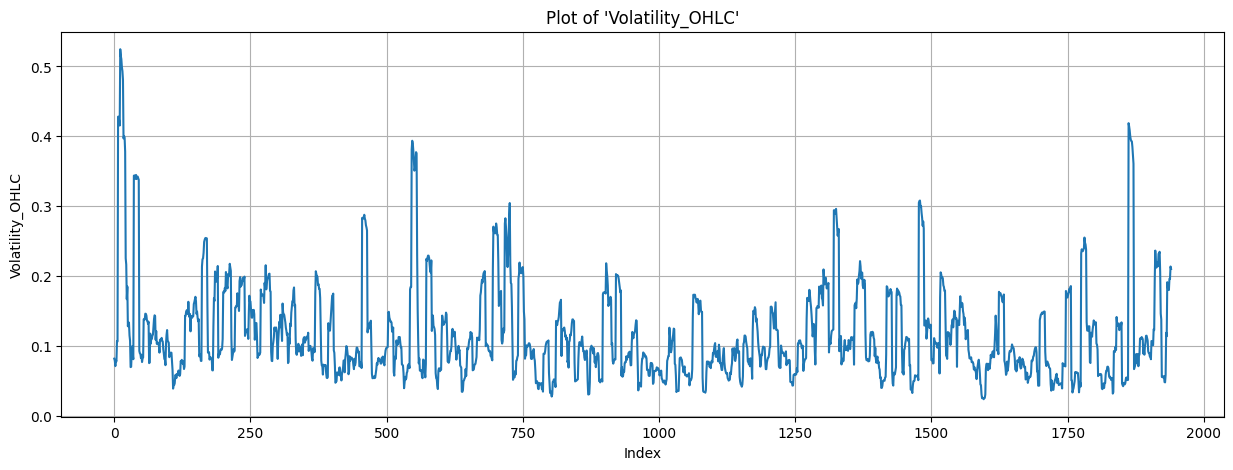

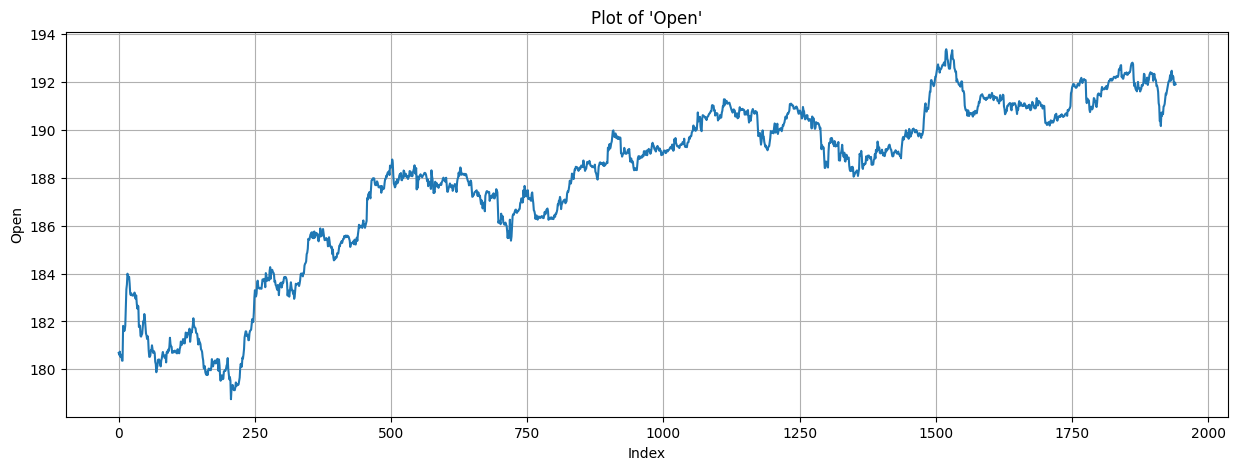

In [9]:
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_nth_column(df, n):
    # Check if the column index n is within the range of DataFrame's columns
    if n < 0 or n >= len(df.columns):
        raise ValueError(f"Column index is out of range. DataFrame has {len(df.columns)} columns.")
    # df = df[0:100]
    
        
    column_name = df.columns[n]
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[column_name])
    # plt.plot(df.index, df['SL'])
    # plt.plot(df.index, df['RL'])
    
    plt.title(f"Plot of '{column_name}'")
    plt.xlabel("Index")
    plt.ylabel(column_name)
    plt.grid(True)
    plt.show()






# # Convert the Date column to datetime and set it as the index
# df['Date'] = pd.to_datetime(df['date'])
# df.set_index('Date', inplace=True)

# # Plotting the candlestick chart
# mpf.plot(df, type='candle', style='charles',
#          title='Sample Candlestick Chart',
#          ylabel='Price')



plot_nth_column(df,24)
plot_nth_column(df,41)
# plot_nth_column(df,1)


In [10]:

signal_multi = [df, df[['date','Close']]]


# set file name here from the above defined list
option = signal_multi[0]
file_name = f'tr_{ticker}_{len(list(option.columns))}.csv'
file_name_test = f'te_{ticker}_{len(list(option.columns))}.csv'
file_name_val = f'val_{ticker}_{len(list(option.columns))}.csv'




df_test = option[-36:]
df_val = option[-72:-36]
# option.iloc[:-72]

print(f'training file saving as {file_name} ') 
print(f'testing file saving as {file_name_test}') 
print(f'validation file saving as {file_name_val}') 

print(option.columns)


def save_df_to_csv(option, file_name):
    option.to_csv(file_name, index=False) 

training file saving as tr_GBPJPY=X_45.csv 
testing file saving as te_GBPJPY=X_45.csv
validation file saving as val_GBPJPY=X_45.csv
Index(['date', 'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X',
       'USDCAD=X', 'USDNOK=X', 'EURGBP=X', 'EURJPY=X', 'AUDJPY=X', 'NZDUSD=X',
       'EURCHF=X', 'EURCAD=X', 'GBPCAD=X', 'GBPAUD=X', 'MACD', 'RSI',
       'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_RANGE', 'Distance_to_BB_Upper',
       'Distance_to_BB_Lower', 'Volatility_OHLC', 'Moving Average2',
       'Moving Average3', 'MA_diff', 'ADX', 'Return', 'HL_Spread',
       'Mean_HL_Price', 'Mean_OC_Price', 'Close_Volatility', 'Volatility',
       'Range', 'Doji', 'Hammer_Signal', 'Engulfing', 'Harami', 'Three_crows',
       'Open', 'High', 'Low', 'Close'],
      dtype='object')


In [11]:

save_df_to_csv(option[:-72], file_name)
save_df_to_csv(df_test, file_name_test)
save_df_to_csv(df_val, file_name_val)
